# Diabetes Classification

## About dataset
- The Behavioral Risk Factor Surveillance System (BRFSS) is a health-related telephone survey that collects data from U.S. residents on their health-related risk behaviors, chronic health conditions, and use of preventive services
- The dataset has been established in 1984 with 15 states, it now collects data from all 50 states, D.C., and 3 U.S. territories
- Over 400,000 adult interviews are completed each year, making it the largest continuous health survey system in the world
- Factors assessed include tobacco use, healthcare coverage, HIV/AIDS knowledge/prevention, physical activity, and fruit/vegetable consumption
- A record in the data corresponds to a single respondent (each from a single household)
- The description of columns can be found in the linked PDF file

#### Features description
| Feature               | Description                                                                  |
|-----------------------|------------------------------------------------------------------------------|
| diabetes              | Subject was told they have diabetes                                          |
| high_blood_pressure   | Subject has high blood pressure                                              |
| high_cholesterol      | Subject has high cholesterol                                                 |
| cholesterol_check     | Subject had cholesterol check within the last five years                     |
| bmi                   | BMI of the subject                                                           |
| smoked_100_cigarettes | Subject has smoked at least 100 cigarettes during their life                 |
| stroke                | Subject experienced stroke during their life                                 |
| coronary_disease      | Subject has/had coronary heart disease or myocardial infarction              |
| exercise              | Subject does regular exercise or physical activity                           |
| consumes_fruit        | Subject consumes fruits at least once a day                                  |
| consumes_vegetables   | Subject consumes vegetables at least once a day                              |
| heavy_alcohol_drinker | Heavy drinkers are defined as adult men having more than 14 drinks per week |
| insurance             | Subject has some kind of health plan (insurance, prepaid plans, ...)         |
| no_doctor_money       | Subject was unable to visit doctor in the past 12 months because of cost     |
| health                | How good is the health of the subject (self rated)                           |
| mental_health         | Number of days in the past month when subject's mental health was not good   |
| physical_health       | Number of days in the past month when subject's physical health was not good |
| climb_difficulty      | Subject has difficulties climbing stairs                                     |
| sex                   | Sex of the subject                                                           |
| age_category          | Age category of the subject                                                  |
| educatation_level     | Highest level of education achieved by the subject                           |
| income                | Income of subject's household                                                |

Load the dataset. All 5 parts are concatenated

In [1]:
from core import load_dataset

dataset = load_dataset("data")

Do basic preprocessing on columns and categorical values in order to make the dataset more humanly readable.

In [2]:
from core import process_columns, remove_unusable_diabetes_categories

process_columns(dataset)

# 'Unnamed: 0' is a duplicate column of ID
dataset.drop("Unnamed: 0", axis="columns", inplace=True)

dataset.drop_duplicates(inplace=True)

    # ID is no longer needed after dropping duplicates
dataset.drop("ID", axis="columns", inplace=True)

# Remove rows where target label is missing
dataset = dataset[~dataset["diabetes"].isna()]

# Random forest model can actually handle classification into multiple categories, so we create a copy
dataset_with_extended_diabetes_categories = dataset.copy()

# Remove pre diabetes and diabetes in pregnancy categories
dataset_without_extended_diabetes_categories = remove_unusable_diabetes_categories(dataset)

{'Diabetes.NO', 'Diabetes.YES'}


Now we create the random forest model

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.calibration import LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.tree import plot_tree

# Assuming dataset_with_extended_diabetes_categories is a pandas DataFrame
dataset = dataset_with_extended_diabetes_categories

# Splitting dataset into features and target
X = dataset.drop("diabetes", axis=1)
y = dataset["diabetes"]
y = LabelEncoder().fit_transform(y)

# Splitting dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Create preprocessing steps
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OrdinalEncoder())
    ]
)

numerical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())]
)

# Create the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, make_column_selector(dtype_include="category")),
        ("num", numerical_transformer, make_column_selector(dtype_exclude="category")),
    ]
)

# Create the pipeline
pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "classifier",
            RandomForestClassifier(class_weight="balanced", max_features=12, min_samples_leaf=3, max_depth=20, criterion="gini", n_estimators=100, random_state=42),
        ),
    ]
)

# param_grid = {
#     "classifier__class_weight": ["balanced", "balanced_subsample"],
#     "classifier__max_depth": [None, 10, 20, 30],
#     "classifier__max_features": [2, 2**2, 2**3, 2**4, 2**5],
#     "classifier__min_samples_leaf": [3, 3**2, 3**3, 3**4, 3**5],
# }
# 
# clf = GridSearchCV(pipeline, param_grid, cv=10, scoring="f1", n_jobs=-1)
# clf.fit(X_train, y_train)
# 
# print(f"Best params: {clf.best_params_}")
# Fit the pipeline
pipeline.fit(X_train, y_train)

random_forest_model = pipeline

We might want to find the best combination of hyper parameters. We want to use GridSearchCV for that purpose.

In [4]:
param_grid = {
    "classifier__class_weight": ["balanced", "balanced_subsample"],
    "classifier__max_depth": [15, 20],
    "classifier__max_features": [2**3, 2**4],
    "classifier__min_samples_leaf": [3, 3**2],
    "classifier__max_leaf_nodes": [50, 100, 200],
}

clf = GridSearchCV(pipeline, param_grid, cv=10, scoring="f1_weighted", n_jobs=-1)
clf.fit(X_train[:5000], y_train[:5000])

print(clf.best_params_)
print(classification_report(y_test, clf.predict(X_test)))

KeyboardInterrupt: 

Let's see how our first model performs.

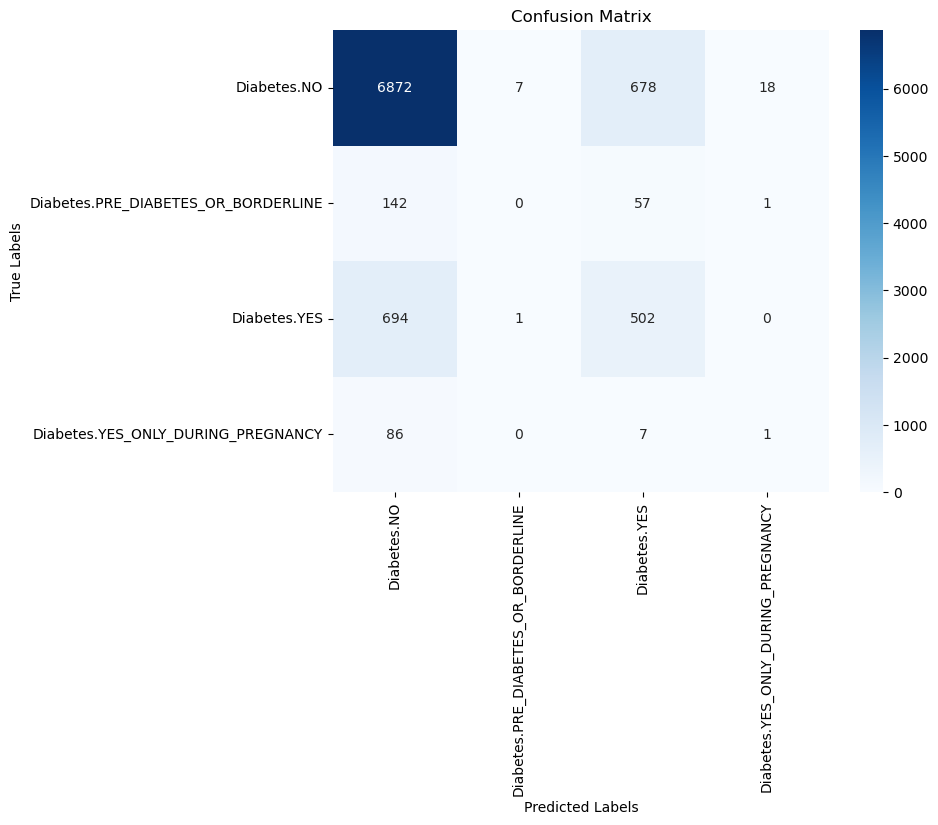

In [ ]:
y_pred = random_forest_model.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

import seaborn as sns
from sklearn.preprocessing import LabelEncoder


def encode_diabetes_column(diabetes_column):
    """
    Encodes the 'diabetes' column of the dataset.

    Parameters:
    - diabetes_column: pandas.Series, the 'diabetes' column from the dataset.

    Returns:
    - y_encoded: The encoded labels for the 'diabetes' column.
    - class_labels: The original string labels corresponding to the encoded labels.
    """
    encoder = LabelEncoder()
    y_encoded = encoder.fit_transform(diabetes_column)
    class_labels = encoder.classes_  # Stores the original string labels
    return class_labels


class_labels = encode_diabetes_column(dataset["diabetes"])

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_labels,
    yticklabels=class_labels,
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

Now we split the dataset into training and testing.

In [5]:
from sklearn.model_selection import train_test_split

dataset = dataset_without_extended_diabetes_categories
diabetes_X, diabetes_y = dataset.drop(columns="diabetes"), dataset.diabetes

diabetes_train_X, diabetes_test_X, diabetes_train_y, diabetes_test_y = train_test_split(
    diabetes_X, diabetes_y, test_size=0.2, random_state=42
)

Create a column transformer to handle categorical data for certain models.

In [16]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Step 1: Identify Categorical Columns
# We select columns with dtype 'category' or 'object'
categorical_cols = dataset.select_dtypes(
    include=["category", "object"]
).columns.tolist()

# Step 2: Create the ColumnTransformer
# We use 'remainder='passthrough'' to keep the non-categorical columns unchanged
column_transformer = ColumnTransformer(
    transformers=[
        (
            "OHE",
            OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
            categorical_cols,
        )
    ],
    remainder="passthrough",
)

# Step 3: Fit and Transform the Data
# The transformed data will be a NumPy array
transformed_data = column_transformer.fit_transform(dataset)

# Optional: Convert the transformed data back to a DataFrame
# This step requires generating the new column names after transformation
new_columns = column_transformer.get_feature_names_out()

# Creating a new DataFrame with the transformed data and new column names
one_hot_encoded_dataset = pd.DataFrame(transformed_data, columns=new_columns) # type: ignore

Review our one hot encoded dataset.

In [17]:
one_hot_encoded_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9040 entries, 0 to 9039
Data columns (total 85 columns):
 #   Column                                                                                      Non-Null Count  Dtype  
---  ------                                                                                      --------------  -----  
 0   OHE__diabetes_Diabetes.NO                                                                   9040 non-null   float64
 1   OHE__diabetes_Diabetes.PRE_DIABETES_OR_BORDERLINE                                           9040 non-null   float64
 2   OHE__diabetes_Diabetes.YES                                                                  9040 non-null   float64
 3   OHE__diabetes_Diabetes.YES_ONLY_DURING_PREGNANCY                                            9040 non-null   float64
 4   OHE__high_blood_pressure_HighBloodPressure.NO                                               9040 non-null   float64
 5   OHE__high_blood_pressure_HighBloodPressur